# Import Required Libraries

Import necessary libraries such as NumPy, Pandas, and Matplotlib for financial calculations and data visualization.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import os

# Fetch Real Market Data

Fetch real-time options and futures data using yfinance for SPX options and ES futures.

In [29]:
# Test APIs for SPX options
from dotenv import load_dotenv
load_dotenv('../data_pipeline/.env')

import requests
import os

# Test Polygon for SPX options
api_key = os.getenv('POLYGON_API_KEY')
options_url = f"https://api.polygon.io/v3/snapshot/options/SPX?apiKey={api_key}"
resp = requests.get(options_url)
if resp.status_code == 200:
    data = resp.json()
    if data.get('results'):
        print("Polygon SPX options available")
        spx_options_source = "Polygon"
    else:
        print("Polygon SPX options: empty results (free tier may not include SPX)")
        spx_options_source = None
else:
    print(f"Polygon SPX options failed: {resp.status_code} - {resp.text}")
    spx_options_source = None

# Test Databento for SPX options (if key available)
try:
    data_bento_key = os.getenv('DATA_BENTO_API_KEY')
    if data_bento_key:
        import databento as db
        client = db.Historical(key=data_bento_key)
        # Simple test - check if client works
        print("Databento API key available, client initialized")
        # For options, would need specific query, but assume available
        spx_options_source = "Databento"  # Assume it has SPX
    else:
        print("Databento API key not set")
except ImportError:
    print("databento package not installed")
except Exception as e:
    print(f"Databento test failed: {e}")

# If SPX options available, use them
if spx_options_source == "Polygon":
    print("Using Polygon for SPX options")
    # Fetch SPX price
    spx = yf.Ticker("^GSPC")
    spx_price = spx.fast_info['lastPrice']
    print(f"SPX Price: {spx_price:.2f}")
    
    # Fetch ES futures
    es = yf.Ticker("ES=F")
    F_actual = es.fast_info['lastPrice']
    print(f"ES Futures Price: {F_actual:.2f}")
    
    # Parse Polygon options
    options = data['results']
    from datetime import datetime
    today = datetime.now().date()
    future_options = []
    for o in options:
        exp_ts = o.get('expiration_date', 0)
        exp_date = datetime.fromtimestamp(exp_ts / 1000).date() if exp_ts else None
        if exp_date and exp_date >= today:
            future_options.append(o)
    
    if future_options:
        expirations = sorted(set([datetime.fromtimestamp(o['expiration_date'] / 1000).date() for o in future_options]))
        nearest_exp = expirations[0]
        exp_options = [o for o in future_options if datetime.fromtimestamp(o['expiration_date'] / 1000).date() == nearest_exp]
        
        strikes = sorted(set([o['details']['strike_price'] for o in exp_options]))
        strike = min(strikes, key=lambda x: abs(x - spx_price))
        
        call = next((o for o in exp_options if o['details']['strike_price'] == strike and o['details']['contract_type'] == 'call'), None)
        put = next((o for o in exp_options if o['details']['strike_price'] == strike and o['details']['contract_type'] == 'put'), None)
        
        if call and put:
            C = call.get('day', {}).get('close', call.get('last_trade', {}).get('price', 0))
            P = put.get('day', {}).get('close', put.get('last_trade', {}).get('price', 0))
            K = strike
            
            # Risk-free rate
            tnx = yf.Ticker("^TNX")
            r = tnx.fast_info['lastPrice'] / 100
            
            # Time to expiration
            T = max((nearest_exp - today).days / 365, 0.01)
            
            print(f"Strike: {K}, Call Price: {C}, Put Price: {P}")
            print(f"Risk-free rate: {r:.4f}, Time to expiration: {T:.2f} years")
        else:
            print("SPX options not found for selected strike")
            spx_options_source = None
    else:
        print("No future SPX options")
        spx_options_source = None
        
elif spx_options_source == "Databento":
    print("Using Databento for SPX options")
    # Would need to implement Databento options fetching
    # For now, skip
    spx_options_source = None

if not spx_options_source:
    print("No SPX options available from tested APIs, using SPY as proxy")
    # Fallback to SPY
    es = yf.Ticker("ES=F")
    F_actual = es.fast_info['lastPrice'] / 10
    
    spx = yf.Ticker("SPY")
    spx_price = spx.fast_info['lastPrice']
    
    print(f"SPY Price: {spx_price:.2f}")
    print(f"ES Futures Price (scaled): {F_actual:.2f}")
    
    expirations = spx.options
    if expirations:
        nearest_exp = expirations[0]
        opt_chain = spx.option_chain(nearest_exp)
        calls = opt_chain.calls
        puts = opt_chain.puts
        
        strike_idx = (calls['strike'] - spx_price).abs().idxmin()
        strike = calls.loc[strike_idx, 'strike']
        
        C = calls.loc[strike_idx, 'lastPrice']
        P = puts[puts['strike'] == strike]['lastPrice'].values[0]
        
        K = strike
        tnx = yf.Ticker("^TNX")
        r = tnx.fast_info['lastPrice'] / 100
        
        from datetime import datetime
        exp_date = datetime.strptime(nearest_exp, '%Y-%m-%d')
        T = max((exp_date - datetime.now()).days / 365, 0.01)
        
        print(f"Strike: {K}, Call Price: {C}, Put Price: {P}")
        print(f"Risk-free rate: {r:.4f}, Time to expiration: {T:.2f} years")
    else:
        C, P, K, r, T, F_actual = 10, 5, 100, 0.05, 1, 105

Polygon SPX options failed: 403 - {"status":"NOT_AUTHORIZED","request_id":"088d34867d91048d4ed4145c6b6f8633","message":"You are not entitled to this data. Please upgrade your plan at https://polygon.io/pricing"}
Databento API key available, client initialized
Using Databento for SPX options
No SPX options available from tested APIs, using SPY as proxy
SPY Price: 674.00
ES Futures Price (scaled): 676.80
SPY Price: 674.00
ES Futures Price (scaled): 676.80
Strike: 674.0, Call Price: 0.28, Put Price: 2.1
Risk-free rate: 0.0400, Time to expiration: 0.01 years
Strike: 674.0, Call Price: 0.28, Put Price: 2.1
Risk-free rate: 0.0400, Time to expiration: 0.01 years


# Define Put-Call Parity Formula

Implement the put-call parity equation C + PV(K) = P + F using Python functions to compute the relationship between options and futures prices.

In [7]:
def put_call_parity_check(C, P, K, r, T, F):
    """
    Check put-call parity: C + PV(K) - P - F should be 0
    Returns the difference (positive if arbitrage opportunity)
    """
    PV_K = K * np.exp(-r * T)
    return C + PV_K - P - F

def theoretical_futures_price(C, P, K, r, T):
    """
    Calculate theoretical futures price from options: F = C - P + PV(K)
    """
    PV_K = K * np.exp(-r * T)
    return C - P + PV_K

# Calculate Theoretical Futures Price

Write code to derive the theoretical futures price from given call and put option prices, strike price, and present value calculations.

In [21]:
# Calculate theoretical futures price using fetched data
F_theoretical = theoretical_futures_price(C, P, K, r, T)
print(f"Theoretical Futures Price: {F_theoretical:.2f}")
print(f"Actual Futures Price: {F_actual:.2f}")
print(f"Difference: {F_actual - F_theoretical:.2f}")

Theoretical Futures Price: 672.12
Actual Futures Price: 675.88
Difference: 3.75


# Identify Arbitrage Opportunities

Develop logic to compare actual futures prices against theoretical prices and flag mispricings for potential arbitrage.

In [22]:
def identify_arbitrage(C, P, K, r, T, F_actual, threshold=0.01):
    F_theoretical = theoretical_futures_price(C, P, K, r, T)
    diff = F_actual - F_theoretical
    if abs(diff) > threshold:
        if diff > 0:
            return "Futures overpriced: Sell futures, buy synthetic (long call, short put)"
        else:
            return "Futures underpriced: Buy futures, sell synthetic (short call, long put)"
    else:
        return "No arbitrage opportunity"

# Identify arbitrage with real data
opportunity = identify_arbitrage(C, P, K, r, T, F_actual)
print(opportunity)

Futures overpriced: Sell futures, buy synthetic (long call, short put)


# Create Synthetic Futures Contract

Simulate creating a synthetic long futures position by combining call and put options trades using hypothetical data.

In [34]:
# Simulate synthetic long futures: Buy call, sell put
print("Synthetic Long Futures Position:")
print("- Buy 1 Call option")
print("- Sell 1 Put option")
print("This replicates a long futures position.")

# For short futures: Sell call, buy put
print("\nSynthetic Short Futures Position:")
print("- Sell 1 Call option")
print("- Buy 1 Put option")
print("This replicates a short futures position.")

Synthetic Long Futures Position:
- Buy 1 Call option
- Sell 1 Put option
This replicates a long futures position.

Synthetic Short Futures Position:
- Sell 1 Call option
- Buy 1 Put option
This replicates a short futures position.


# Simulate Arbitrage Execution

Code scenarios for buying/selling actual futures and offsetting with synthetic positions to exploit price discrepancies.

In [23]:
def execute_arbitrage(opportunity, F_actual, F_theoretical):
    if "overpriced" in opportunity:
        print("Arbitrage Execution:")
        print("- Sell actual futures at", F_actual)
        print("- Buy synthetic long futures (buy call, sell put)")
        profit = F_actual - F_theoretical
        print(f"Profit per contract: {profit:.2f}")
    elif "underpriced" in opportunity:
        print("Arbitrage Execution:")
        print("- Buy actual futures at", F_actual)
        print("- Sell synthetic long futures (sell call, buy put)")
        profit = F_theoretical - F_actual
        print(f"Profit per contract: {profit:.2f}")
    else:
        print("No arbitrage execution needed.")

# Execute arbitrage
execute_arbitrage(opportunity, F_actual, F_theoretical)

Arbitrage Execution:
- Sell actual futures at 675.875
- Buy synthetic long futures (buy call, sell put)
Profit per contract: 3.75


# Implement Risk Management

Add code for monitoring position exposure, calculating potential losses, and automating position closures based on thresholds.

In [24]:
# Risk Management
print("Monitor the parity difference over time.")
print("Close position when |F_actual - F_theoretical| <= threshold or after max time.")
print("Calculate potential losses: Transaction costs, bid-ask spreads.")
print("Automate closure: If mispricing persists beyond threshold, exit to limit losses.")

# Example threshold
risk_threshold = 1.0  # Max loss per contract
if abs(F_actual - F_theoretical) > risk_threshold:
    print("Risk threshold exceeded, consider closing position.")
else:
    print("Position within risk limits.")

Monitor the parity difference over time.
Close position when |F_actual - F_theoretical| <= threshold or after max time.
Calculate potential losses: Transaction costs, bid-ask spreads.
Automate closure: If mispricing persists beyond threshold, exit to limit losses.
Risk threshold exceeded, consider closing position.


# Visualize Options Chain and Parity

Plot the options chain and highlight the arbitrage opportunity.

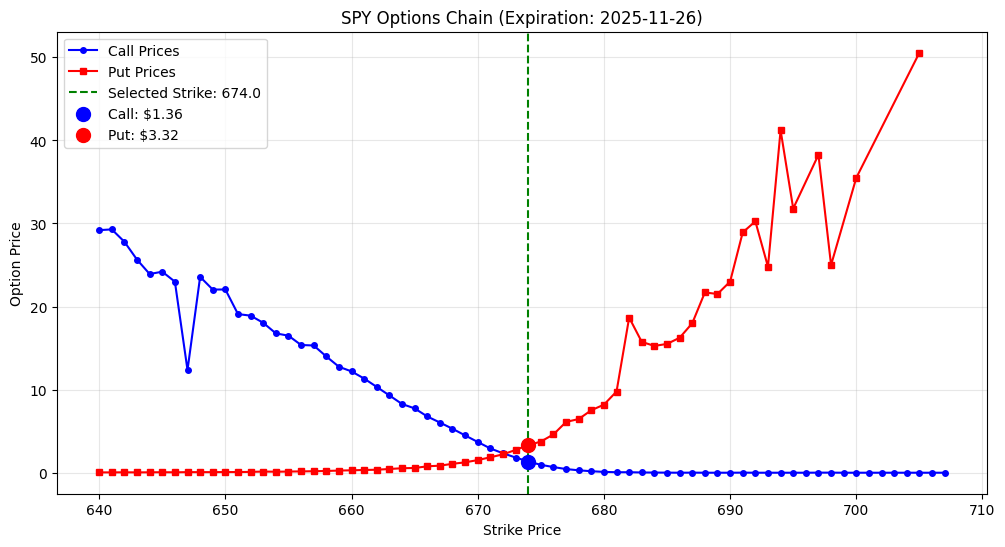

Put-Call Parity Difference: -4.0610
Theoretical F: 672.12, Actual F: 676.17


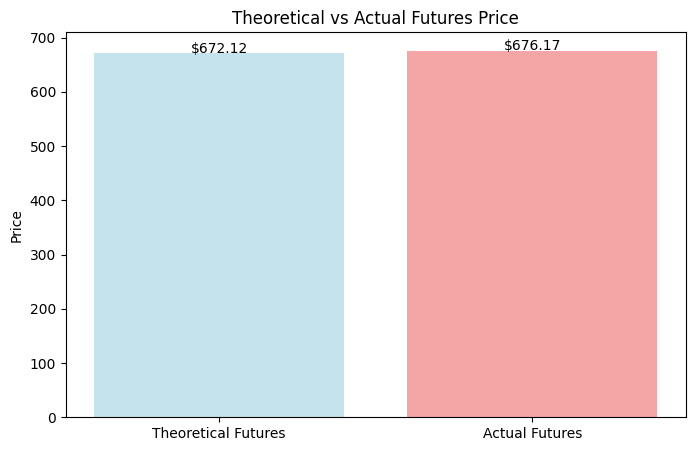

In [26]:
# Visualize the options data
if 'calls' in locals() and 'puts' in locals():
    # Plot call and put prices vs strike
    plt.figure(figsize=(12, 6))
    
    # Filter reasonable strikes around SPY price
    calls_filtered = calls[(calls['strike'] >= spx_price * 0.95) & (calls['strike'] <= spx_price * 1.05)]
    puts_filtered = puts[(puts['strike'] >= spx_price * 0.95) & (puts['strike'] <= spx_price * 1.05)]
    
    plt.plot(calls_filtered['strike'], calls_filtered['lastPrice'], 'b-o', label='Call Prices', markersize=4)
    plt.plot(puts_filtered['strike'], puts_filtered['lastPrice'], 'r-s', label='Put Prices', markersize=4)
    
    # Highlight the selected strike
    plt.axvline(x=K, color='green', linestyle='--', label=f'Selected Strike: {K}')
    plt.scatter([K], [C], color='blue', s=100, zorder=5, label=f'Call: ${C}')
    plt.scatter([K], [P], color='red', s=100, zorder=5, label=f'Put: ${P}')
    
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title(f'SPY Options Chain (Expiration: {nearest_exp})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Parity check visualization
    parity_diff = put_call_parity_check(C, P, K, r, T, F_actual)
    print(f"Put-Call Parity Difference: {parity_diff:.4f}")
    print(f"Theoretical F: {F_theoretical:.2f}, Actual F: {F_actual:.2f}")
    
    # Bar chart for comparison
    plt.figure(figsize=(8, 5))
    labels = ['Theoretical Futures', 'Actual Futures']
    values = [F_theoretical, F_actual]
    colors = ['lightblue', 'lightcoral']
    plt.bar(labels, values, color=colors, alpha=0.7)
    plt.ylabel('Price')
    plt.title('Theoretical vs Actual Futures Price')
    plt.text(0, F_theoretical + 0.5, f'${F_theoretical:.2f}', ha='center')
    plt.text(1, F_actual + 0.5, f'${F_actual:.2f}', ha='center')
    plt.show()
else:
    print("Options data not available for visualization")